実データ解析


In [1]:
from datetime import datetime
import re
import os
from pathlib import Path
from pprint import pprint
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy as sp
from scipy.optimize import leastsq
import scipy.optimize as optimize
from scipy.optimize import curve_fit  

import warnings
warnings.simplefilter('ignore')
# warnings.resetwarnings()
# warnings.simplefilter('ignore', FutureWarning)


from pfit import power_fit as powfit
from pfit import sim_func as simf

%load_ext autoreload
%autoreload 2

plt.rcParams["figure.dpi"] = 100
plt.rcParams['font.size'] = 14
# np.random.seed(100)

In [2]:
# PYS
pys_path = Path(r"data")
p_lists = list(pys_path.glob('*.dat'))
pprint(p_lists)
print(f'files:{len(p_lists)}')

[WindowsPath('data/Au 20120313165555_2372.dat'),
 WindowsPath('data/PTCBI 20170620205101_7916.dat')]
files:2


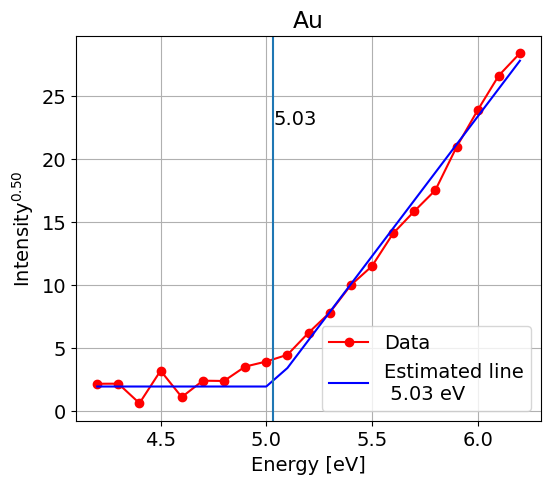

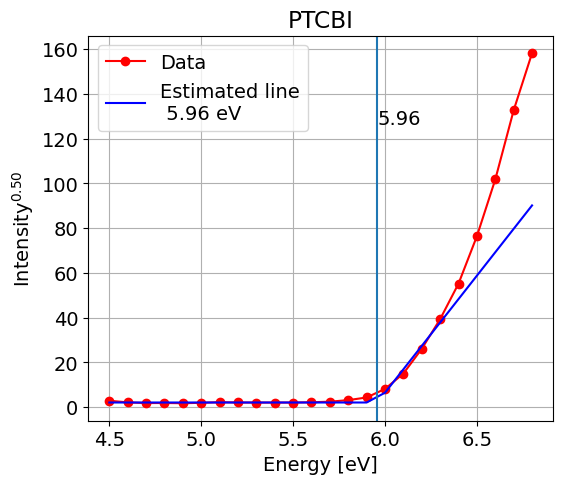

In [3]:
from reader import datconv as dv

for inum, i in  enumerate(p_lists):
    acdata = dv.AcConv(str(i))
    acdata.convert()
            
    fig =plt.figure(figsize=(6,5)) 
    ax = fig.add_subplot(111)
    ax.set_title(f'{acdata.metadata["sampleName"]}')
    ax.plot(acdata.df["uvEnergy"],acdata.df["npyield"],'ro-',label='Data')
    ax.plot(acdata.df["uvEnergy"],acdata.df["guideline"],'b-',label=f'Estimated line\n {acdata.metadata["thresholdEnergy"]:.2f} eV')
    ax.legend()
    ax.grid()
    ax.axvline(acdata.metadata["thresholdEnergy"] )
    ax.text(acdata.metadata["thresholdEnergy"] ,np.max(acdata.df["npyield"])*0.8, f'{acdata.metadata["thresholdEnergy"]:.2f}')
    ax.set_xlabel('Energy [eV]')
    ax.set_ylabel(f'Intensity$^{{{acdata.metadata["powerNumber"]:.2f}}}$')

Au 20120313165555_2372
5.03


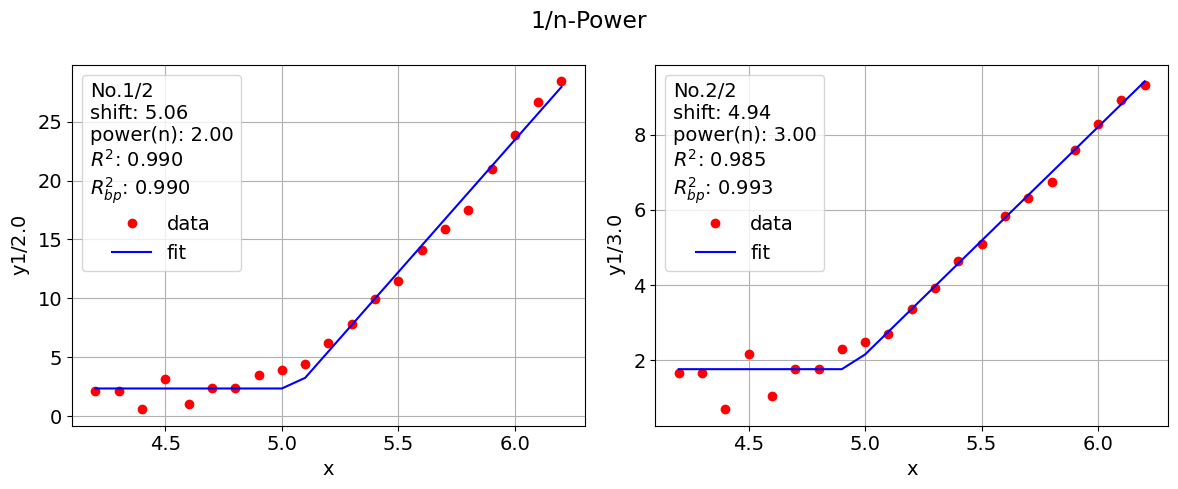

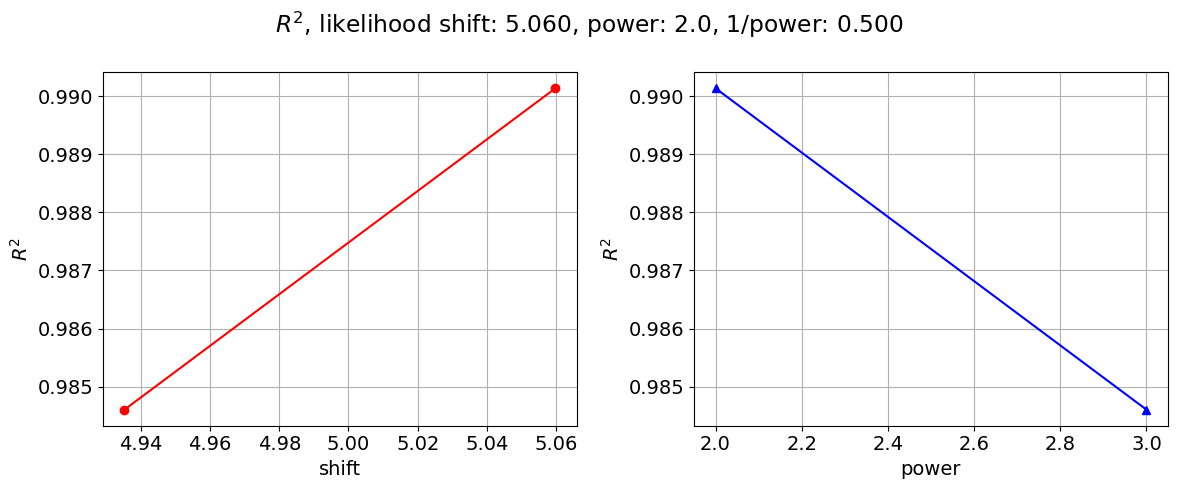

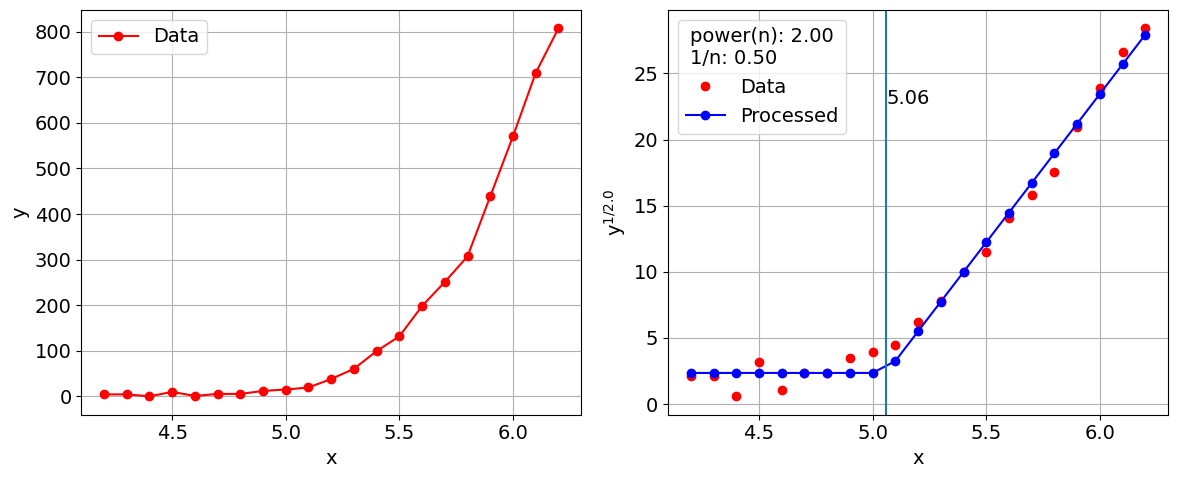

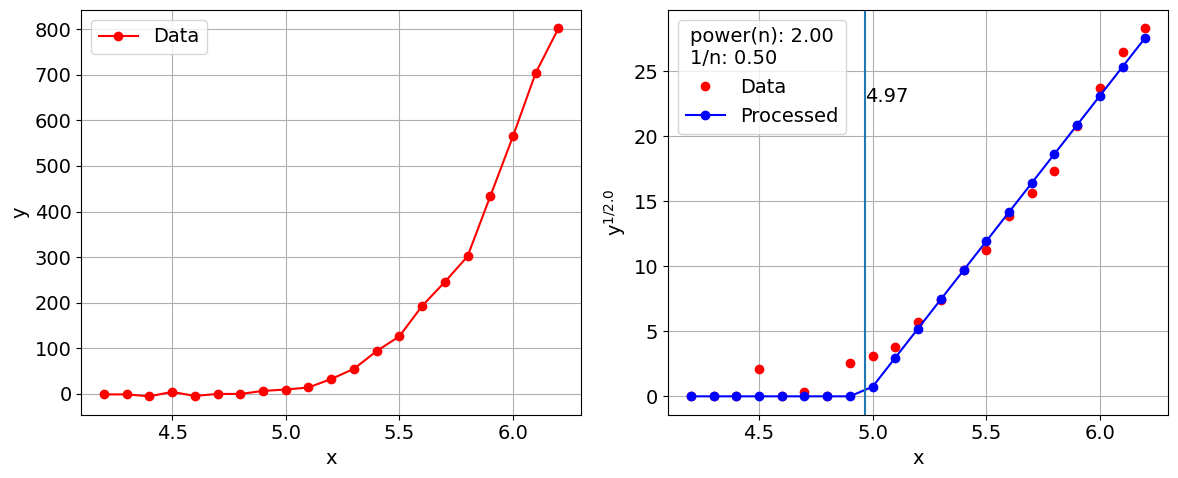

shift: 5.06, power: 2.00, r2:0.99
-*-*-*-*-*-*-*-*-*-*
PTCBI 20170620205101_7916
5.96


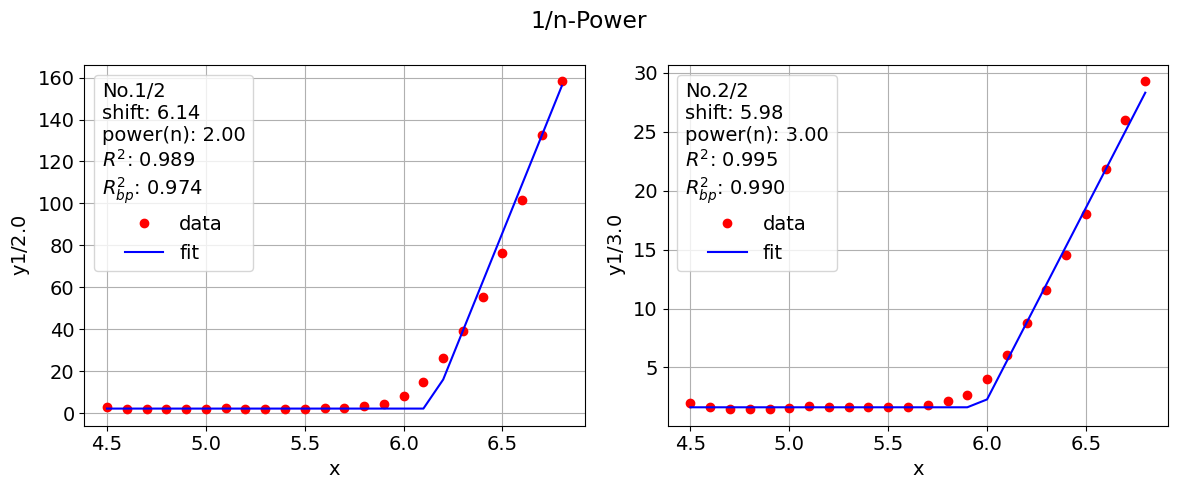

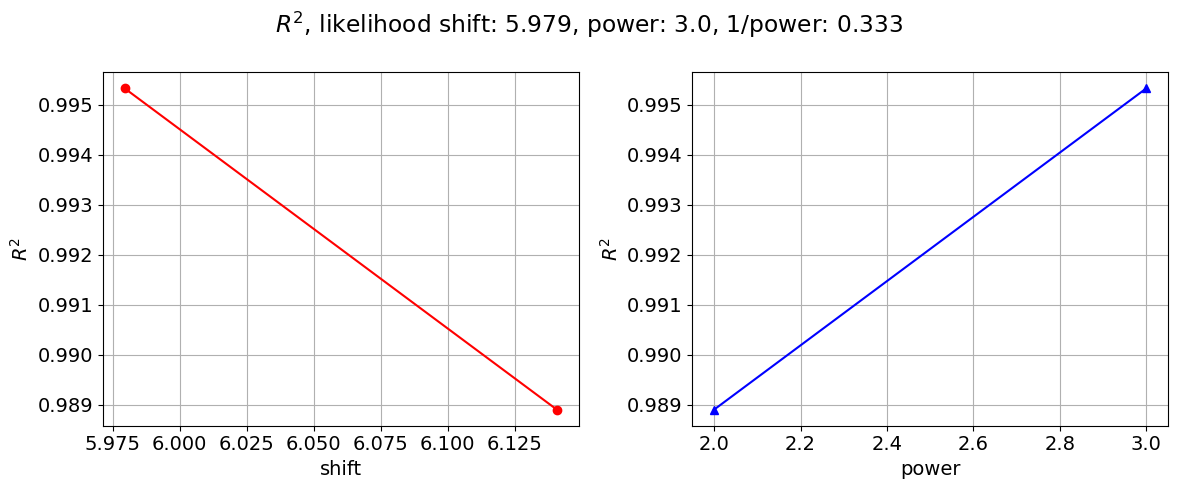

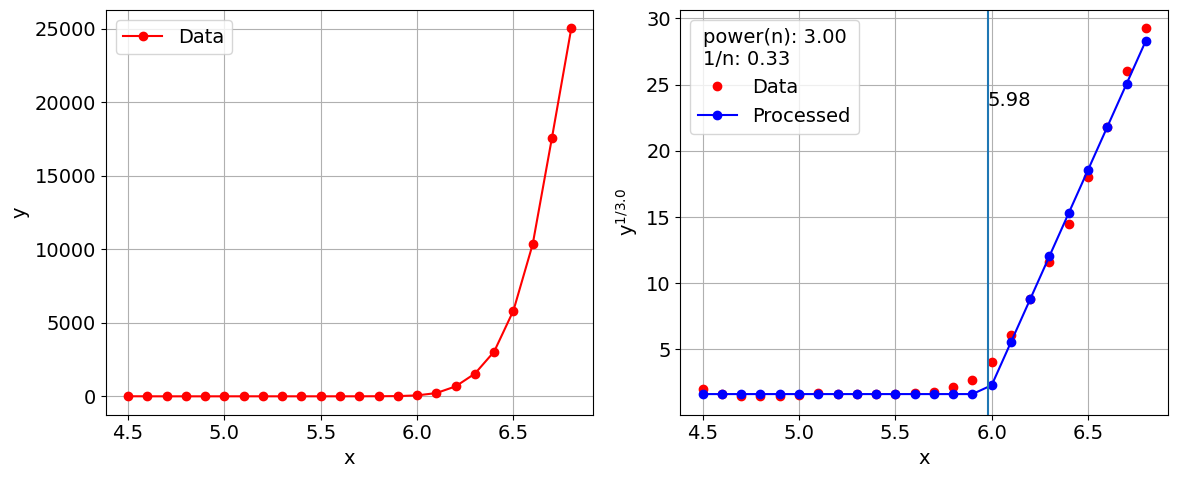

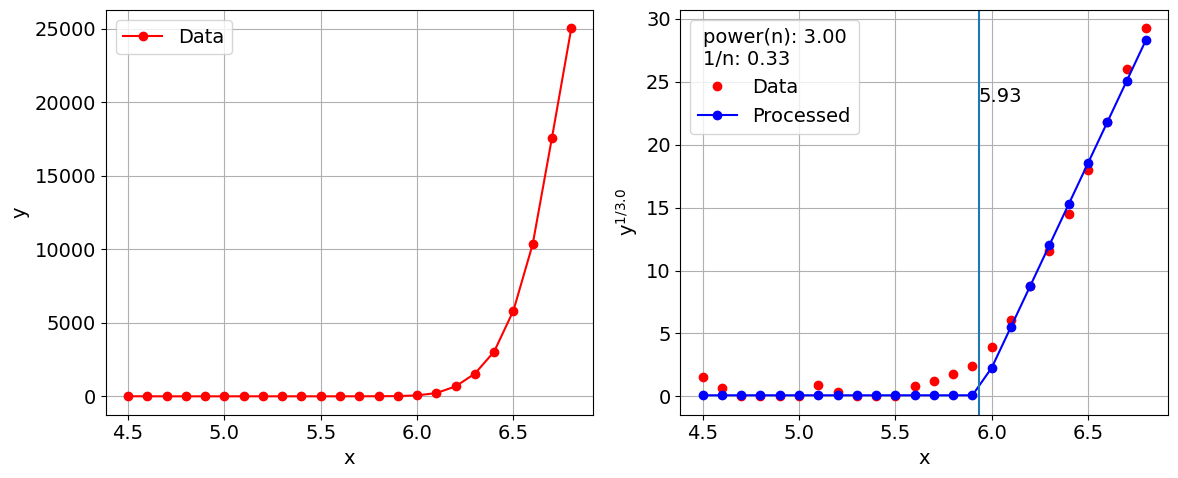

shift: 5.98, power: 3.00, r2:1.00
-*-*-*-*-*-*-*-*-*-*


In [4]:
plotinfo = True
for inum, i in  enumerate(p_lists):
    
    acdata = dv.AcConv(str(i))
    acdata.convert()
    
    x_data = acdata.df["uvEnergy"].values 
    y_data = acdata.df["pyield"].values
    
    print(f'{i.stem}') 
    print(f'{acdata.estimate_value["thresholdEnergy"]:.2f}')
    
    temp = powfit.PfAnalysis(x_data,y_data)
    # print('Constant Power')
    temp.shift_estimate_by_power_scan(search_range=[2,3,],
                                        zero_replace=True,
                                        info=False, 
                                        min_error='mae',
                                        likely_evaluation='r2',
                                        plot=plotinfo)
    

    print(f'shift: {temp.shebypw["shift"]:.2f}, power: {temp.shebypw["power"]:.2f}, r2:{temp.shebypw["r2"]:.2f}')
    print('-*'*10)

In [7]:
from reader import SuperConlib2 as scl2

spctest =scl2.SuperConM(r'data\s1_2021_09m10d10h47m33.txt') 
spctest.read_file()
spctest.estimate_n_j0()
spctest.meta

660 131.041764


{'slope': 5.11538607840173,
 'slice': -3.311348858420065,
 'j0': 1.918972,
 'jc': 1.5438347238318695,
 'magnetic_filed': 3}

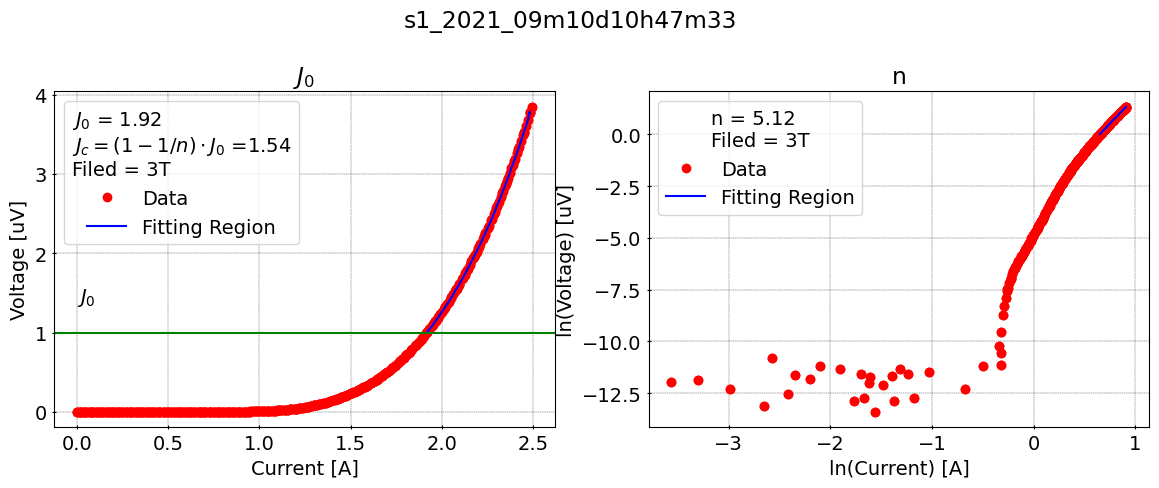

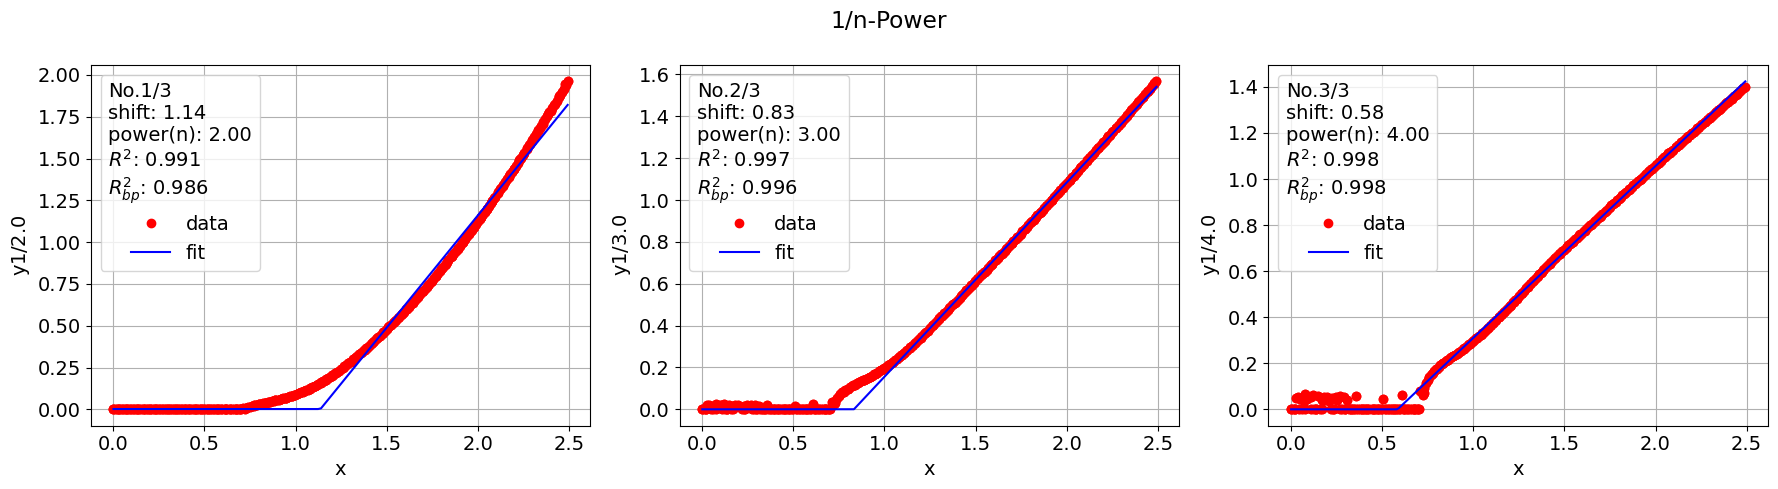

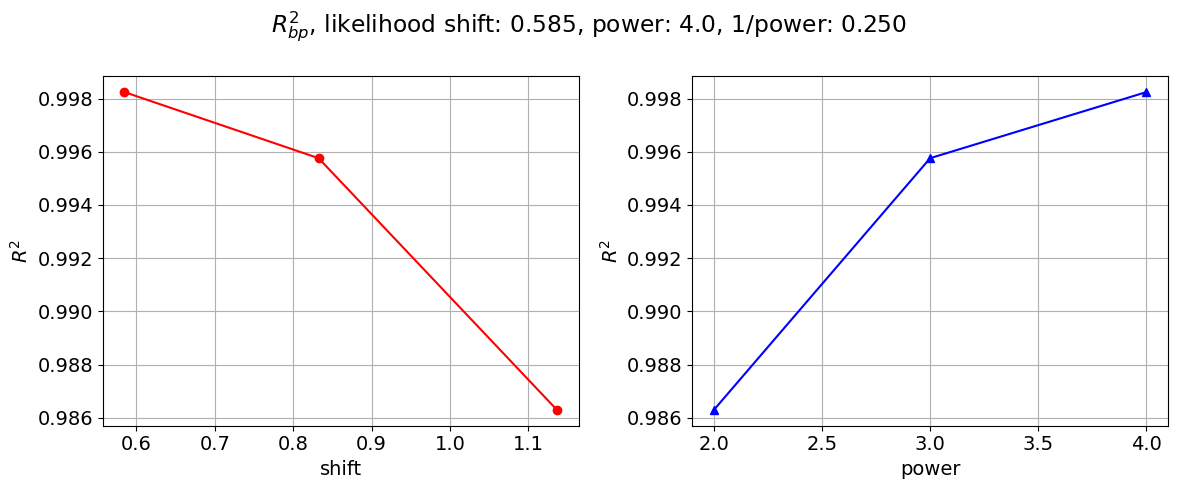

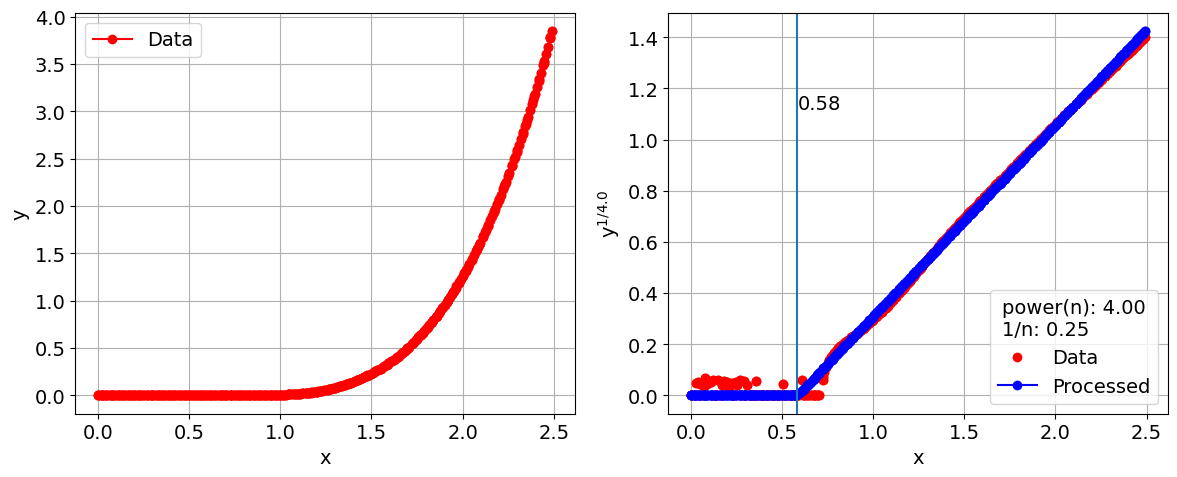

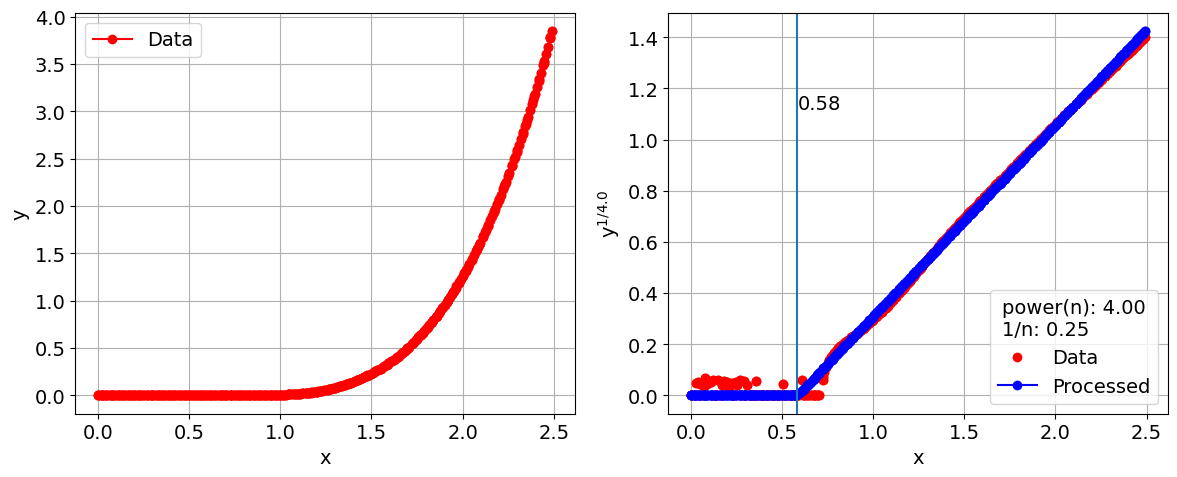

shift: 0.58, power: 4.00, r2:1.00
popt bg:-0.000
bg1:-0.000
bg2 from fit :0.000


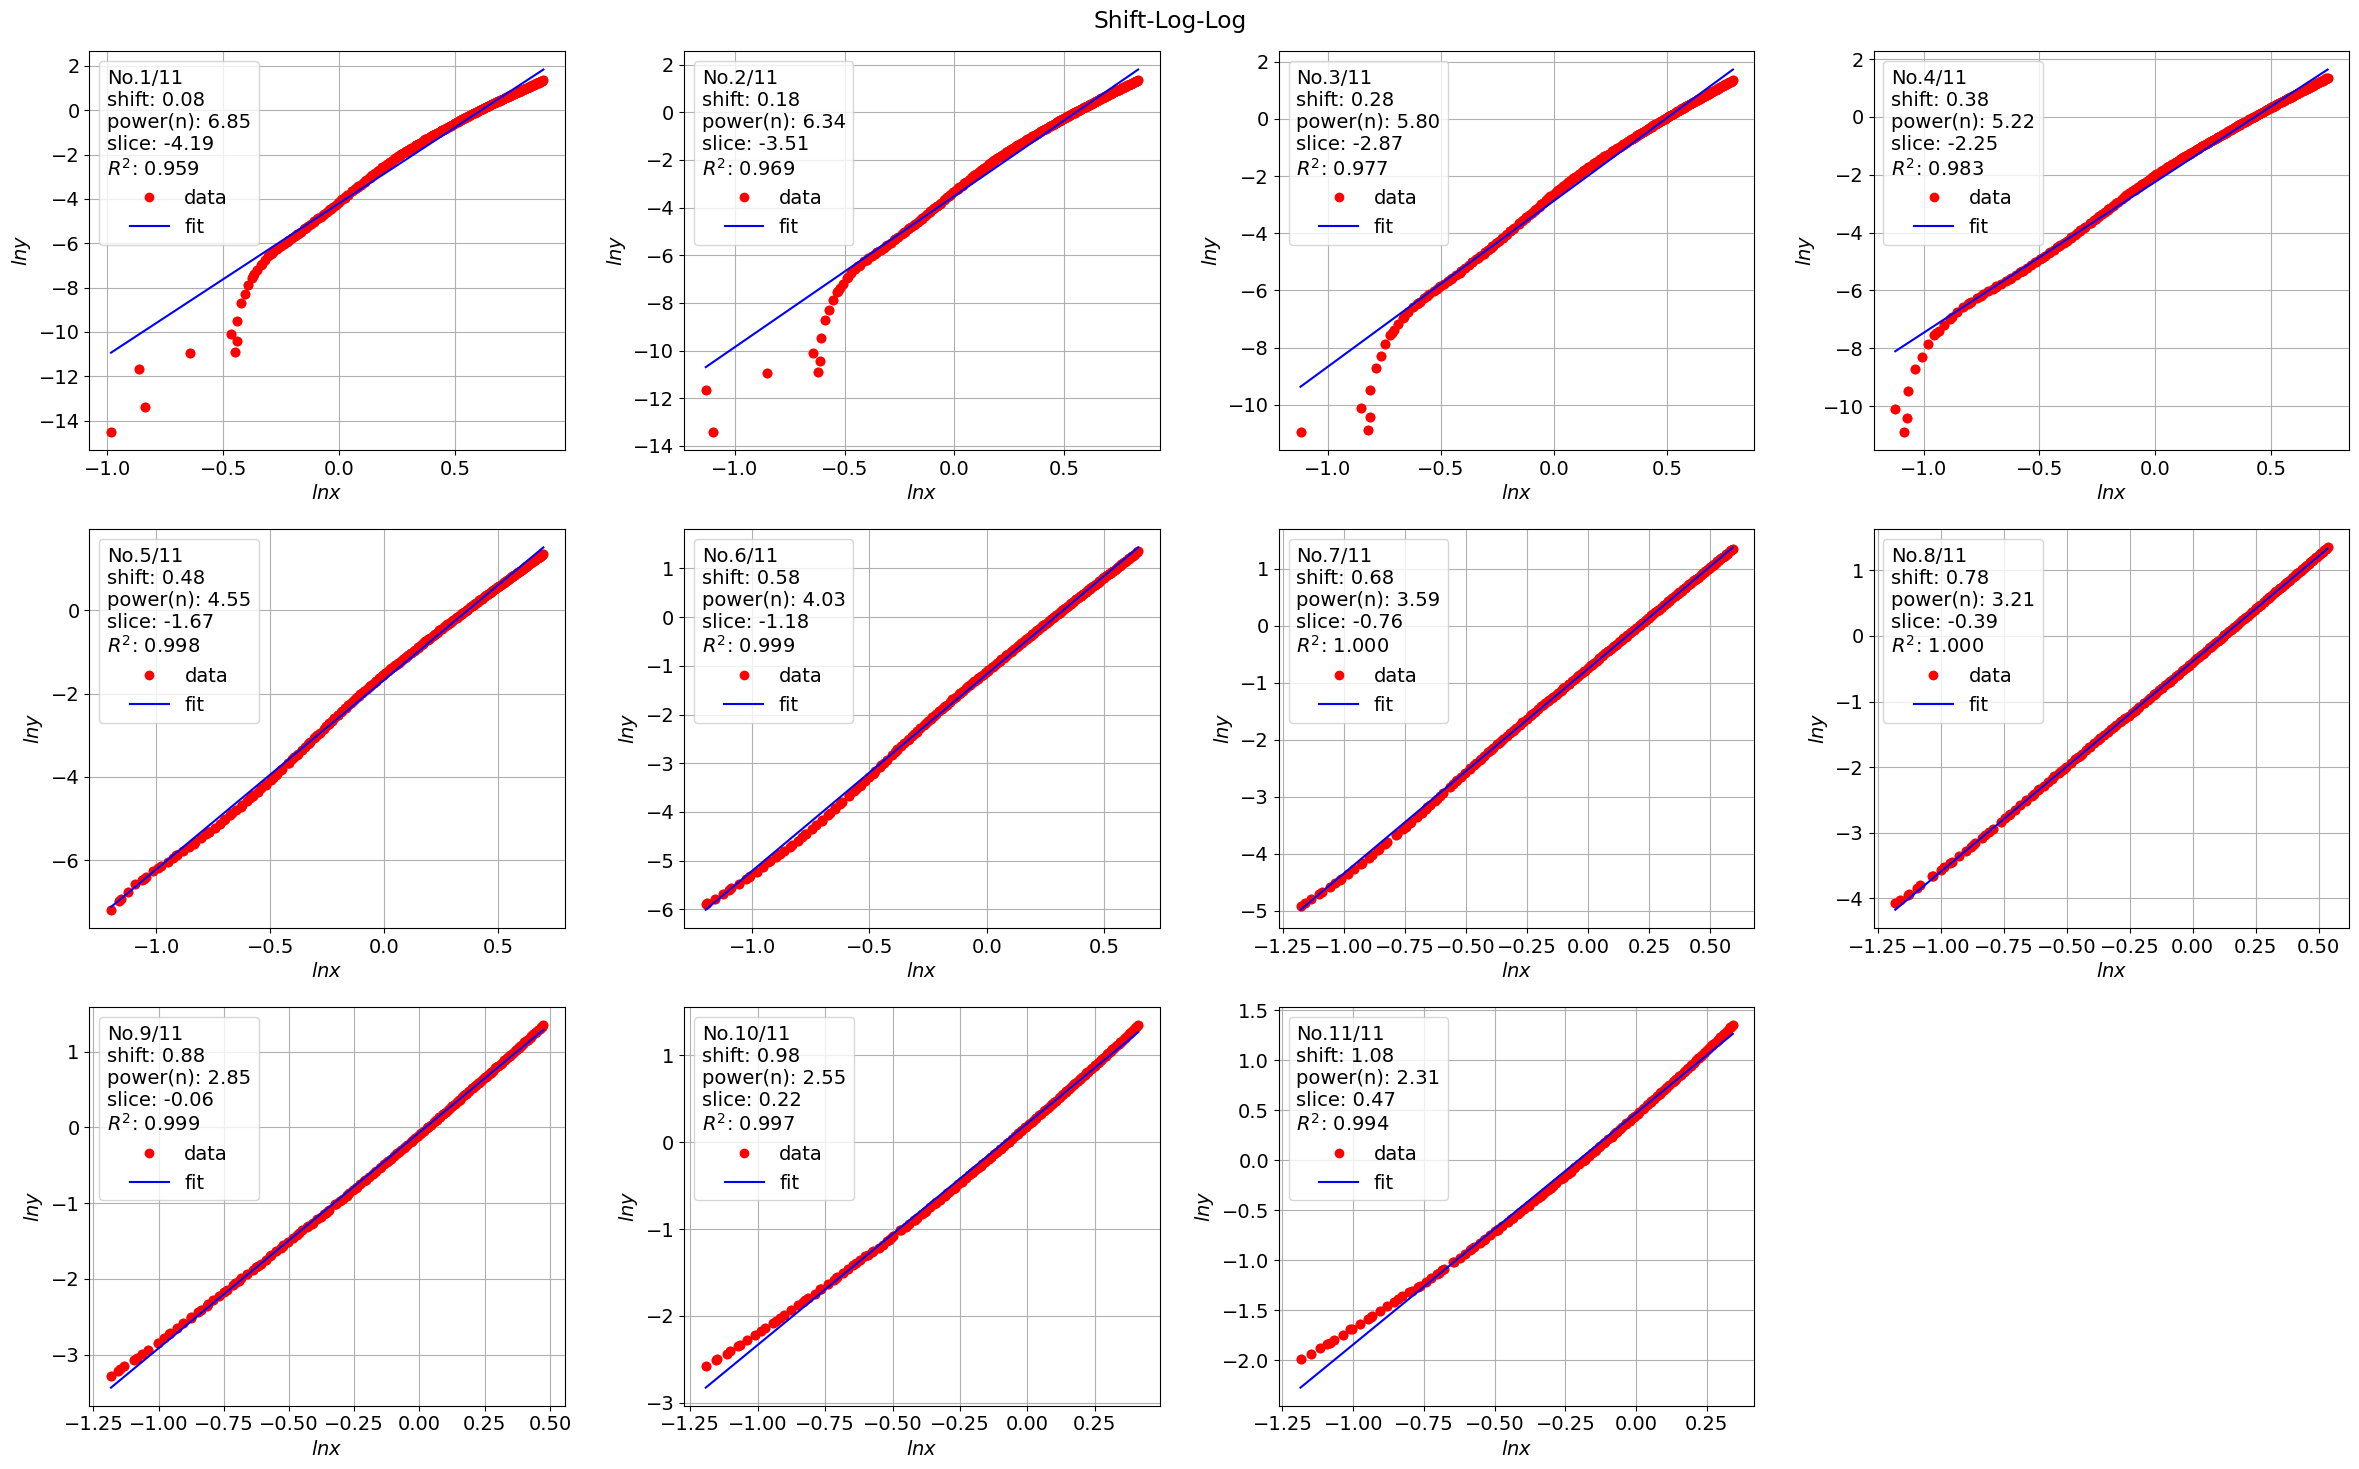

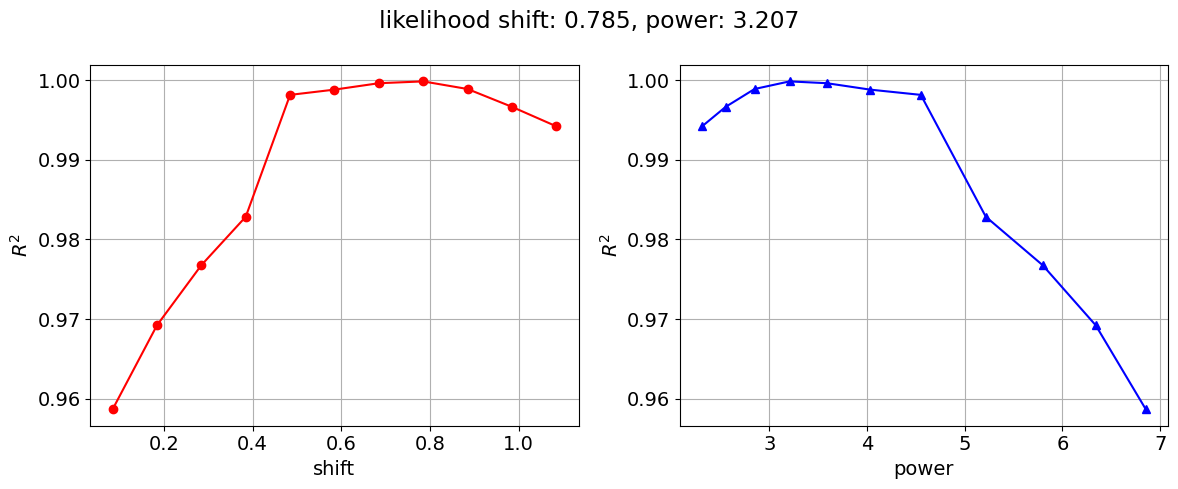

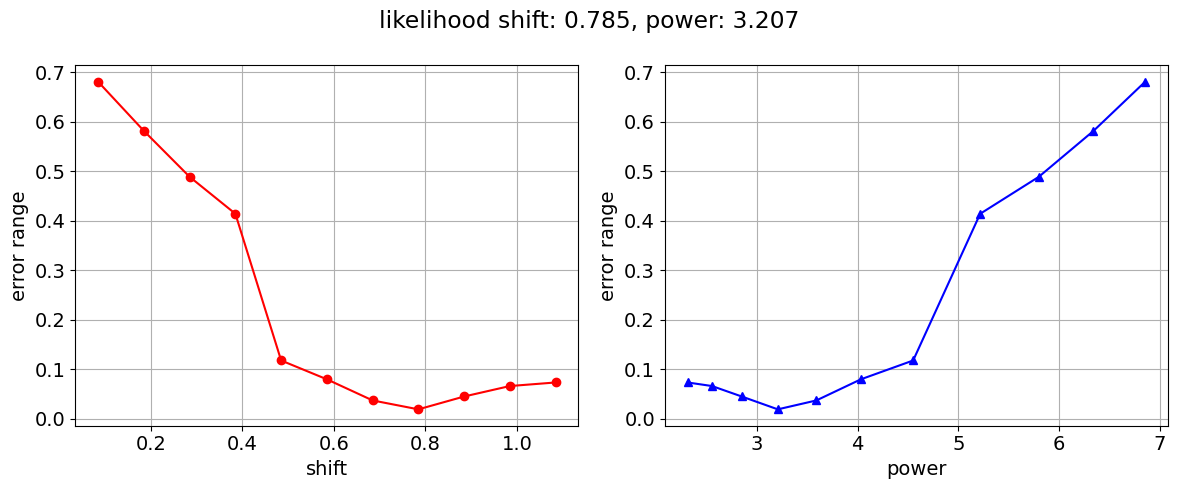

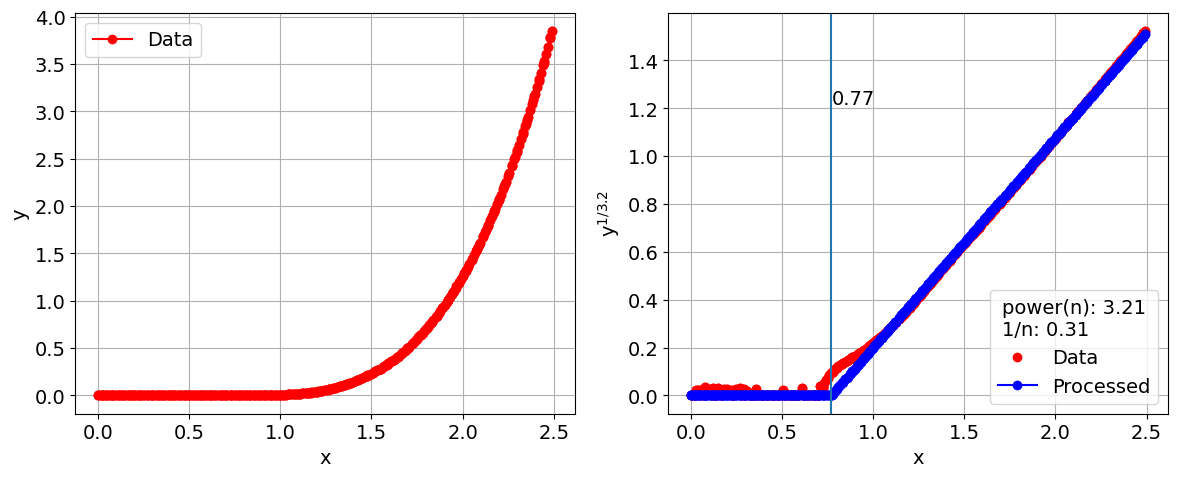

Margin: 0.3, shift: 0.78, power: 3.21
R2: 1.00, ER: 0.02
-*-*-*-*-*-*-*-*-*-*


In [8]:
plotinfo = True
im = 0.3
# im=0.5

spx = spctest.df['current'].values
spy = spctest.df['voltage'].values

spctest.make_plots()


temp = powfit.PfAnalysis(spx,spy)
# print('Constant Power')
temp.shift_estimate_by_power_scan(search_range=[2,3,4,],
                                zero_replace=True,
                                info=False, 
                                min_error='mae',
                                plot=plotinfo)

# print(temp.shebypw["popt"][2]**temp.shebypw["power"])
# print(temp.shebypw["fit"])
print(f'shift: {temp.shebypw["shift"]:.2f}, power: {temp.shebypw["power"]:.2f}, r2:{temp.shebypw["r2"]:.2f}')
bg1 = np.mean(temp.ydata[:5])
bg2 = temp.shebypw["popt"][2]**temp.shebypw["power"]
print(f'popt bg:{temp.shebypw["popt"][2]:.3f}')
print(f'bg1:{bg1:.3f}')
print(f'bg2 from fit :{bg2:.3f}')

if bg2 <= 0:
    bg2 = 0
temp.ydata = temp.ydata - bg2 # fittingした値でBgを引く

search_range = powfit.create_serach_range(temp.shebypw["shift"], 0.5, 0.1)

temp.power_estimate_by_shift_scan(search_range=search_range, 
                                fit_type='mae', 
                                # fit_type='weight',
                                lim_val=im,
                                info=False,
                                plot=True)
    

print(f'Margin: {im}, shift: {temp.pwebysh["shift"]:.2f}, power: {temp.pwebysh["power"]:.2f}')
print(f'R2: {temp.pwebysh["r2"]:.2f}, ER: {temp.pwebysh["er"]:.2f}')

# temp.shift_estimate_by_power_scan(search_range=[2,3,],
#                                   zero_replace=True,
#                                     info=False, 
#                                     min_error='mae',
#                                     plot=plotinfo)

# print(f'shift: {temp.shebypw["shift"]:.2f}, power: {temp.shebypw["power"]:.2f}, r2:{temp.shebypw["r2"]:.2f}')

print('-*'*10)